In [7]:
import pickle as cPickle
import gzip
import sys
# Third-party libraries
import numpy as np

def load_data():
    """Return the MNIST data as a tuple containing the training data,
    the validation data, and the test data.
    The ``training_data`` is returned as a tuple with two entries.
    The first entry contains the actual training images.  This is a
    numpy ndarray with 50,000 entries.  Each entry is, in turn, a
    numpy ndarray with 784 values, representing the 28 * 28 = 784
    pixels in a single MNIST image.
    The second entry in the ``training_data`` tuple is a numpy ndarray
    containing 50,000 entries.  Those entries are just the digit
    values (0...9) for the corresponding images contained in the first
    entry of the tuple.
    The ``validation_data`` and ``test_data`` are similar, except
    each contains only 10,000 images.
    This is a nice data format, but for use in neural networks it's
    helpful to modify the format of the ``training_data`` a little.
    That's done in the wrapper function ``load_data_wrapper()``, see
    below.
    """
    f = gzip.open('./Data/mnist.pkl.gz', 'rb')
    if sys.version_info < (3,):
        training_data, validation_data, test_data = cPickle.load(f)
    else:
        training_data, validation_data, test_data = cPickle.load(f, encoding='bytes')
    f.close()
    return (training_data, validation_data, test_data)

def load_data_wrapper():
    """Return a tuple containing ``(training_data, validation_data,
    test_data)``. Based on ``load_data``, but the format is more
    convenient for use in our implementation of neural networks.
    In particular, ``training_data`` is a list containing 50,000
    2-tuples ``(x, y)``.  ``x`` is a 784-dimensional numpy.ndarray
    containing the input image.  ``y`` is a 10-dimensional
    numpy.ndarray representing the unit vector corresponding to the
    correct digit for ``x``.
    ``validation_data`` and ``test_data`` are lists containing 10,000
    2-tuples ``(x, y)``.  In each case, ``x`` is a 784-dimensional
    numpy.ndarry containing the input image, and ``y`` is the
    corresponding classification, i.e., the digit values (integers)
    corresponding to ``x``.
    Obviously, this means we're using slightly different formats for
    the training data and the validation / test data.  These formats
    turn out to be the most convenient for use in our neural network
    code."""
    tr_d, va_d, te_d = load_data()
    training_inputs = [np.reshape(x, (784, 1)) for x in tr_d[0]]
    training_results = [vectorized_result(y) for y in tr_d[1]]
    training_data = list(zip(training_inputs, training_results))
    validation_inputs = [np.reshape(x, (784, 1)) for x in va_d[0]]
    validation_data = list(zip(validation_inputs, va_d[1]))
    test_inputs = [np.reshape(x, (784, 1)) for x in te_d[0]]
    test_data = list(zip(test_inputs, te_d[1]))
    return (training_data, validation_data, test_data)

def vectorized_result(j):
    """Return a 10-dimensional unit vector with a 1.0 in the jth
    position and zeroes elsewhere.  This is used to convert a digit
    (0...9) into a corresponding desired output from the neural
    network."""
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

In [8]:
import random

# Third-party libraries
import numpy as np

plot_x=[]
plot_y=[]
guess = np.zeros((10,1))
correct = np.zeros((10,1))
wrong = np.zeros((10,1))
class Network(object):

    def __init__(self, sizes):
        """The list ``sizes`` contains the number of neurons in the
        respective layers of the network.  For example, if the list
        was [2, 3, 1] then it would be a three-layer network, with the
        first layer containing 2 neurons, the second layer 3 neurons,
        and the third layer 1 neuron.  The biases and weights for the
        network are initialized randomly, using a Gaussian
        distribution with mean 0, and variance 1.  Note that the first
        layer is assumed to be an input layer, and by convention we
        won't set any biases for those neurons, since biases are only
        ever used in computing the outputs from later layers."""
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(sizes[:-1], sizes[1:])]

    def feedforward(self, a):
        """Return the output of the network if ``a`` is input."""
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a)+b)
        return a

    def SGD(self, training_data, epochs, mini_batch_size, eta,
            test_data=None):
        """Train the neural network using mini-batch stochastic
        gradient descent.  The ``training_data`` is a list of tuples
        ``(x, y)`` representing the training inputs and the desired
        outputs.  The other non-optional parameters are
        self-explanatory.  If ``test_data`` is provided then the
        network will be evaluated against the test data after each
        epoch, and partial progress printed out.  This is useful for
        tracking progress, but slows things down substantially."""
        if test_data: n_test = len(test_data)
        n = len(training_data)
        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)
            if test_data:
                print ("Epoch {0}: {1} / {2}".format(
                    j, self.evaluate(test_data), n_test))
                plot_x.append(j)
                plot_y.append(self.evaluate(test_data))
            else:
                print ("Epoch {0} complete".format(j))

    def update_mini_batch(self, mini_batch, eta):
        """Update the network's weights and biases by applying
        gradient descent using backpropagation to a single mini batch.
        The ``mini_batch`` is a list of tuples ``(x, y)``, and ``eta``
        is the learning rate."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [w-(eta/len(mini_batch))*nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb
                       for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, x, y):
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.  ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        # backward pass
        delta = self.cost_derivative(activations[-1], y) * \
            sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        # Note that the variable l in the loop below is used a little
        # differently to the notation in Chapter 2 of the book.  Here,
        # l = 1 means the last layer of neurons, l = 2 is the
        # second-last layer, and so on.  It's a renumbering of the
        # scheme in the book, used here to take advantage of the fact
        # that Python can use negative indices in lists.
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)

    def evaluate(self, test_data):
        """Return the number of test inputs for which the neural
        network outputs the correct result. Note that the neural
        network's output is assumed to be the index of whichever
        neuron in the final layer has the highest activation."""
        test_results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results)

    def cost_derivative(self, output_activations, y):
        """Return the vector of partial derivatives \partial C_x /
        \partial a for the output activations."""
        return (output_activations-y)
    def total_correct(self,test_data):
        test_results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in test_data]
        for(x,y) in test_results:
            correct[y]+=1
            if(x == y):
                guess[y]+=1
            else:
                wrong[y]+=1
        for i in range(10):
            print(int(guess[i])," out of ",int(correct[i])," are correctly identified")
    def test_image(self,test_data):
        arr = np.asarray(test_data[0])
        img1 = arr.reshape((28,28))
        plt.imshow(arr.reshape((28,28)), cmap=plt.get_cmap('gray'))
        print("Correct Label: ", test_data[1], " Identified as: ", np.argmax(net.feedforward(arr)))
            
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))

In [9]:
net =Network([784, 64, 32, 16, 10])

In [10]:
training_data, validation_data, test_daeta = load_data_wrapper()
print("No. of Training Samples: ",len(training_data))
print("No. of Cross Validation Samples: ",len(validation_data))
print("No. of Testing Samples: ",ln(test_data))

No. of Training Samples:  50000
No. of Cross Validation Samples:  10000
No. of Testing Samples:  10000


In [11]:
net.SGD(training_data,30, 64, 3.0, test_data=validation_data)

Epoch 0: 7512 / 10000
Epoch 1: 8158 / 10000
Epoch 2: 8326 / 10000
Epoch 3: 9020 / 10000
Epoch 4: 9221 / 10000
Epoch 5: 9238 / 10000
Epoch 6: 9306 / 10000
Epoch 7: 9332 / 10000
Epoch 8: 9374 / 10000
Epoch 9: 9359 / 10000
Epoch 10: 9386 / 10000
Epoch 11: 9371 / 10000
Epoch 12: 9416 / 10000
Epoch 13: 9417 / 10000
Epoch 14: 9443 / 10000
Epoch 15: 9434 / 10000
Epoch 16: 9448 / 10000
Epoch 17: 9451 / 10000
Epoch 18: 9459 / 10000
Epoch 19: 9470 / 10000
Epoch 20: 9469 / 10000
Epoch 21: 9474 / 10000
Epoch 22: 9459 / 10000
Epoch 23: 9462 / 10000
Epoch 24: 9466 / 10000
Epoch 25: 9487 / 10000
Epoch 26: 9483 / 10000
Epoch 27: 9478 / 10000
Epoch 28: 9478 / 10000
Epoch 29: 9483 / 10000


In [40]:
from jupyterthemes import jtplot
jtplot.style()
#jtplot.style(context='talk', fscale=1.4, spines=False, gridlines='--')
#jtplot.style(ticks=True, grid=False, figsize=(6, 4.5))
#jtplot.reset()

Text(0, 0.5, 'Correctly classified images out of validation dataset')

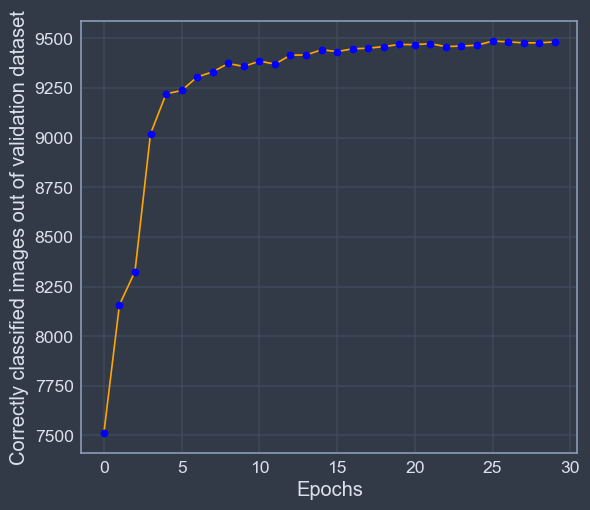

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
plt.plot(plot_x,plot_y,color="orange",marker="o",markerfacecolor="blue")
plt.xlabel("Epochs")
plt.ylabel("Correctly classified images out of validation dataset")

In [13]:
print(net.evaluate(test_data)/len(test_data)*100,"%")

94.62 %


In [14]:
net.total_correct(test_data)

960  out of  980  are correctly identified
1115  out of  1135  are correctly identified
968  out of  1032  are correctly identified
952  out of  1010  are correctly identified
929  out of  982  are correctly identified
822  out of  892  are correctly identified
916  out of  958  are correctly identified
977  out of  1028  are correctly identified
911  out of  974  are correctly identified
912  out of  1009  are correctly identified


In [15]:
test_results = [(np.argmax(net.feedforward(x)), y)
                        for (x, y) in test_data]

In [16]:
correct=[]
guess=[]
for (x,y) in test_results:
    guess.append(x)
    correct.append(y)

In [17]:
from sklearn.metrics import precision_score, recall_score,f1_score,accuracy_score,confusion_matrix

In [48]:
print(precision_score(correct,guess,average=None))

[0.96192385 0.97379913 0.94439024 0.92158761 0.93179539 0.93515358
 0.96016771 0.96256158 0.92113246 0.94507772]


In [19]:
print(recall_score(correct,guess,average=None))

[0.97959184 0.98237885 0.9379845  0.94257426 0.94602851 0.92152466
 0.95615866 0.95038911 0.93531828 0.90386521]


In [20]:
print(f1_score(correct,guess,average=None))

[0.97067745 0.97807018 0.94117647 0.9319628  0.93885801 0.9282891
 0.958159   0.95643661 0.92817117 0.92401216]


In [21]:
print(accuracy_score(correct,guess))

0.9462


<AxesSubplot:>

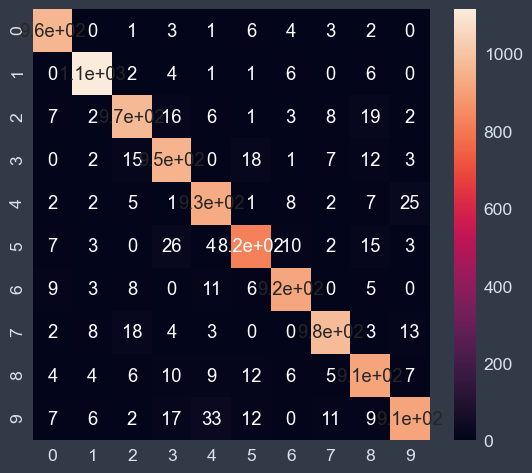

In [49]:
import seaborn as sn
cmap = sn.cubehelix_palette(light=1, as_cmap=True)
sn.heatmap(confusion_matrix(correct,guess),annot=True)

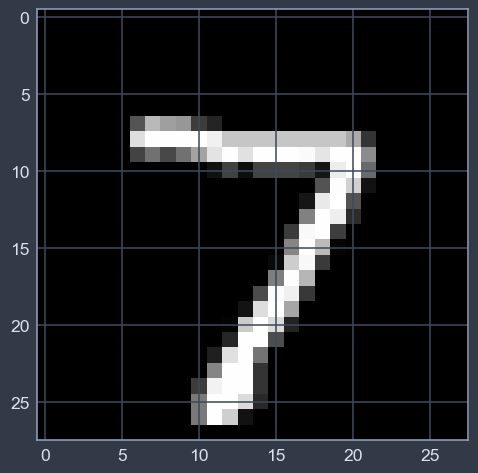

In [55]:
import matplotlib.pyplot as plt
plt.imshow(np.asarray(test_data[0][0]).reshape((28,28)), cmap=plt.get_cmap('gray'))

Correct Label:  9  Identified as:  3


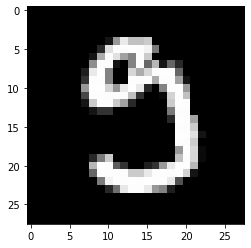

In [18]:
net.test_image(test_data[1247])

In [56]:
print(confusion_matrix(correct,guess))

[[ 960    0    1    3    1    6    4    3    2    0]
 [   0 1115    2    4    1    1    6    0    6    0]
 [   7    2  968   16    6    1    3    8   19    2]
 [   0    2   15  952    0   18    1    7   12    3]
 [   2    2    5    1  929    1    8    2    7   25]
 [   7    3    0   26    4  822   10    2   15    3]
 [   9    3    8    0   11    6  916    0    5    0]
 [   2    8   18    4    3    0    0  977    3   13]
 [   4    4    6   10    9   12    6    5  911    7]
 [   7    6    2   17   33   12    0   11    9  912]]
